In [1]:
%matplotlib inline

# Common imports

In [2]:
from Bio import SeqIO
from matplotlib import pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import statsmodels.stats

from scipy import stats
# # from scipy import spatial
# # import json

from collections import Counter


import datetime
year = datetime.date.today().year
month = datetime.date.today().month
import os
results_dir = '../Results/{}_{:02}'.format(year, month)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Parameters to make pretty-ish plots

In [3]:
import matplotlib
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['axes.labelsize'] = 10
matplotlib.rcParams['axes.titlesize'] = 10

matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = '0.5'
matplotlib.rcParams['grid.linewidth'] = '0.5'

matplotlib.rcParams['axes.edgecolor'] = '0.25'
matplotlib.rcParams['xtick.color'] = '0'
matplotlib.rcParams['ytick.color'] = '0'

matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.weight']='normal'
matplotlib.rcParams['axes.axisbelow'] = True

# Some mapping parameters

In [4]:
mapping_offset = -9
utr_length_to_include = 50

# Read in the genome sequence data

In [5]:
genome_file = '../Genome_files/U00096.3.fasta'
genome_seq = list(SeqIO.parse(genome_file, 'fasta'))[0]
organism = 'Escherichia'

In [6]:
utr_sequence_dict = {}
full_sequence_dict = {}
strand_dict = {}
location_dict = {}
genbank_seq = list(SeqIO.parse('../Genome_files/U00096.3.gb', 'genbank'))[0]
for feature in genbank_seq.features:
    if feature.type != 'CDS':
        continue
    elif 'pseudo' in feature.qualifiers:
        continue
    name = feature.qualifiers['locus_tag'][0] + '_' + feature.qualifiers['gene'][0]
    start = feature.location.start
    end = feature.location.end
    ###Sequence for positive strand genes
    if feature.strand == 1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include])
    ###Sequence for negative strand genes needs to be reverse complemented
    elif feature.strand == -1:
        seq = str(genbank_seq.seq[start-utr_length_to_include:end+utr_length_to_include].reverse_complement())
    
    full_sequence_dict[name] = seq
    
    ###Separately just grab the 5'UTR as its own dictionary because it may be helpful
    utr_seq = seq[:utr_length_to_include]
    utr_sequence_dict[name] = utr_seq
    
    ###Store strand and locations
    strand_dict[name] = feature.strand
    location_dict[name] = (start, end)

print(len(utr_sequence_dict.keys()))
print(len(full_sequence_dict.keys()))
print(len(strand_dict.keys()))
print(len(location_dict.keys()))

4240
4240
4240
4240


# Read in sample .wig files and load all the mapped read data

In [7]:
sample_files = [('WTrep1_ribo', '../WTrep1.ribo_cigar_fulladjust_f.wig', '../WTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep2_ribo', '../WTrep2.ribo_cigar_fulladjust_f.wig', '../WTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_ribo', '../RIBOTrep1.ribo_cigar_fulladjust_f.wig', '../RIBOTrep1.ribo_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_ribo', '../RIBOTrep2.ribo_cigar_fulladjust_f.wig', '../RIBOTrep2.ribo_cigar_fulladjust_r.wig'),\
               ('WTrep1_rna', '../WTrep1.rna_cigar_fulladjust_f.wig', '../WTrep1.rna_cigar_fulladjust_r.wig'),\
               ('WTrep2_rna', '../WTrep2.rna_cigar_fulladjust_f.wig', '../WTrep2.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep1_rna', '../RIBOTrep1.rna_cigar_fulladjust_f.wig', '../RIBOTrep1.rna_cigar_fulladjust_r.wig'),\
               ('RIBOTrep2_rna', '../RIBOTrep2.rna_cigar_fulladjust_f.wig', '../RIBOTrep2.rna_cigar_fulladjust_r.wig')]

sample_names = [i[0] for i in sample_files]

In [8]:
feature_dict_meta = {}
for sample_file in sample_files[:]:
    sample_name, fwd, rev = sample_file
    print('##### {}'.format(sample_name))
    feature_dict_meta[sample_name] = {}
    ################################
    ###Essentially get the fwd and rev genome coverage
    fwd_dicty = {}
    rev_dicty = {}
    with open(fwd) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                fwd_dicty[int(split_line[0])+mapping_offset] = float(split_line[1])#Note: mapping offset addition
    print('Done with fwd')
    with open(rev) as infile:
        for line in enumerate(infile):
            if line[0] > 0:###Ignore the first line of the file
                split_line = line[1].split('\t')
                rev_dicty[int(split_line[0])-mapping_offset] = float(split_line[1])#Note: mapping offset subtraction
    print('Done with rev')

    for gene_name in full_sequence_dict.keys():        
        ####Dealing with positive strand genes first
        if strand_dict[gene_name] == 1:
            ###Get all positions that I care about
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            ###Append read values and if there are none, append zero
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(fwd_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing
        ####And repeat for negative strand genes
        elif strand_dict[gene_name] == -1:
            pos = (location_dict[gene_name][0]-utr_length_to_include, location_dict[gene_name][1]+utr_length_to_include)
            if pos[1] < pos[0]:
                print('found a bug')
                continue
            sequencing = []
            for i in range(pos[0], pos[1]+1):
                try:
                    sequencing.append(rev_dicty[i])
                except KeyError:
                    sequencing.append(0)
            feature_dict_meta[sample_name][gene_name] = sequencing[::-1]###Note the CRUCIAL reverse here

##### WTrep1_ribo
Done with fwd
Done with rev
##### WTrep2_ribo
Done with fwd
Done with rev
##### RIBOTrep1_ribo
Done with fwd
Done with rev
##### RIBOTrep2_ribo
Done with fwd
Done with rev
##### WTrep1_rna
Done with fwd
Done with rev
##### WTrep2_rna
Done with fwd
Done with rev
##### RIBOTrep1_rna
Done with fwd
Done with rev
##### RIBOTrep2_rna
Done with fwd
Done with rev


# Show total read counts for each sample and store

**This is for RPKM normalization. For "total mapped reads" I will only consider total reads mapped to CDSs. Note that this may double count some small number of partially overlapping genes but this should be inconsequential**

In [9]:
total_read_dict = {}
for i in sample_names:
    all_features = []
    for j in feature_dict_meta[i].values():
        all_features.extend(j[utr_length_to_include:-1*utr_length_to_include])
    print(i, np.sum(all_features))
    total_read_dict[i] = np.sum(all_features)

WTrep1_ribo 23170241.0
WTrep2_ribo 16098468.0
RIBOTrep1_ribo 12256307.0
RIBOTrep2_ribo 14035023.0
WTrep1_rna 4128696.0
WTrep2_rna 3909237.0
RIBOTrep1_rna 4243296.0
RIBOTrep2_rna 3062815.0


# Create datatable of RPKM counts for each sample

**Defining TE here as: `RPKM_ribo/RPKM_rna`**

**Also replacing any/all "infinite" values with NaN**

In [10]:
df_master = pd.DataFrame()
for sample in sample_names:
    print(sample)
    for gene in strand_dict.keys():
        gene_len = location_dict[gene][1]-location_dict[gene][0]
        ###Only calculating averages across the CDS (ignoring UTRs)
        reads = feature_dict_meta[sample][gene][utr_length_to_include:-1*utr_length_to_include]
        ###This is the formula for making these values RPKM
        df_master.set_value(gene, sample, (np.sum(reads)*10e9)/(total_read_dict[sample]*gene_len))

###Just dividing each replicate pair (ribo and rna) to create TE measurements        
for ribo_sample in sample_names[:4]:
    rna_sample = ribo_sample.replace('_ribo', '_rna')
    df_master[ribo_sample.replace('_ribo', '_TE')] = df_master[ribo_sample]/df_master[rna_sample]
    ###Remove infinite values, or rather call then NaN
    df_master[ribo_sample.replace('_ribo', '_TE')].replace(np.inf, np.nan, inplace=True)
    df_master[ribo_sample.replace('_ribo', '_TE')].replace(-np.inf, np.nan, inplace=True)

WTrep1_ribo
WTrep2_ribo
RIBOTrep1_ribo
RIBOTrep2_ribo
WTrep1_rna
WTrep2_rna
RIBOTrep1_rna
RIBOTrep2_rna


**Calculate condition averages for Translation Efficiency and log2 fold changes**

In [11]:
###Calculate averages and fold change
df_master['WT_avg_TE'] = df_master[['WTrep1_TE', 'WTrep2_TE']].mean(skipna=False, axis=1)
df_master['RIBOT_avg_TE'] = df_master[['RIBOTrep1_TE', 'RIBOTrep2_TE']].mean(skipna=False, axis=1)
###Fold changes
df_master['log2FC_TE'] = df_master['RIBOT_avg_TE'].apply(np.log2) - df_master['WT_avg_TE'].apply(np.log2)
###Remove the infinite values
df_master['log2FC_TE'].replace(np.inf, np.nan, inplace=True)
df_master['log2FC_TE'].replace(-np.inf, np.nan, inplace=True)
df_master.head()

,WTrep1_ribo,WTrep2_ribo,RIBOTrep1_ribo,RIBOTrep2_ribo,WTrep1_rna,WTrep2_rna,RIBOTrep1_rna,RIBOTrep2_rna,WTrep1_TE,WTrep2_TE,RIBOTrep1_TE,RIBOTrep2_TE,WT_avg_TE,RIBOT_avg_TE,log2FC_TE
b2038_rfbC,4068.375162,4308.163902,4686.344425,4414.200463,2738.938330,2466.357773,2719.871213,2586.230952,1.485384,1.746772,1.723002,1.706808,1.616078,1.714905,0.085632
b3984_rplA,116360.433661,117636.849025,119257.748233,121758.221032,203941.918804,196033.247801,204785.275175,200890.612114,0.570557,0.600086,0.582355,0.606092,0.585321,0.594224,0.021777
b3751_rbsB,1926.403843,1855.862509,1405.630089,1203.498816,1720.731462,1501.522983,1219.326165,1044.350768,1.119526,1.235987,1.152793,1.152389,1.177756,1.152591,-0.031161
b3412_bioH,566.494351,591.367064,485.734193,464.836774,549.756995,640.340440,403.474624,389.594380,1.030445,0.923520,1.203878,1.193130,0.976982,1.198504,0.294830
b3727_pstC,345.720041,318.353274,339.111121,273.868450,615.610030,762.083922,900.930943,846.851671,0.561589,0.417740,0.376401,0.323396,0.489665,0.349898,-0.484859


**Assessing the statistical significance of differences in TE using independent t-tests for each gene**

Which is to say, for each gene I have 2 conditions and 2 samples in each condition so I am simply comparing: 

    [WT_rep1_TE, WT_rep2_TE] against [RIBOT_rep1_TE, RIBOT_rep2_TE]
    
And reporting the raw p-value from this (which will subsequently be adjusted for multiple testing)

In [12]:
df_master['raw_ttest_pval'] = np.nan
for index in df_master.index:
    a = [df_master.loc[index]['WTrep1_TE'], df_master.loc[index]['WTrep2_TE']]
    b = [df_master.loc[index]['RIBOTrep1_TE'], df_master.loc[index]['RIBOTrep2_TE']]
    tval, pval = stats.ttest_ind(a, b, equal_var=True)
    df_master.set_value(index, 'raw_ttest_pval', pval)

**About that multiple testing... Here I'm converting each p-value into a FDR corrected p-value using the pretty standard "Benjamini-Hochberg" procedure**

In [13]:
tempy = df_master[df_master['raw_ttest_pval'].isnull()==False]
sigs, new_pvals, trash1, trash2 = statsmodels.stats.multitest.multipletests(list(tempy['raw_ttest_pval']),\
                                                                        alpha=0.05, method='fdr_bh')
tempy['fdr_corrected_pval_bh'] = new_pvals
df_master['fdr_corrected_pval_bh'] = np.nan
for index in tempy.index:
    df_master.set_value(index, 'fdr_corrected_pval_bh', tempy.loc[index]['fdr_corrected_pval_bh'])

/Users/adamhockenberry/.pyenv/versions/anaconda3-2.0.1/lib/python3.4/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


** A quick glance shows genes sorted for significance **

In [14]:
df_master.sort_values('raw_ttest_pval', inplace=True)

In [15]:
df_master.head(n=20)

,WTrep1_ribo,WTrep2_ribo,RIBOTrep1_ribo,RIBOTrep2_ribo,WTrep1_rna,WTrep2_rna,RIBOTrep1_rna,RIBOTrep2_rna,WTrep1_TE,WTrep2_TE,RIBOTrep1_TE,RIBOTrep2_TE,WT_avg_TE,RIBOT_avg_TE,log2FC_TE,raw_ttest_pval,fdr_corrected_pval_bh
b3472_dcrB,6812.594757,7125.725358,5158.634363,5064.136255,4002.062029,4180.889013,7526.103263,7589.008020,1.702271,1.704356,0.685432,0.667299,1.703314,0.676366,-1.332469,0.000079,0.14064
b3084_rlmG,477.138281,540.866622,346.598784,370.351312,387.701978,440.964478,462.211845,488.166183,1.230683,1.226554,0.749870,0.758658,1.228618,0.754264,-0.703895,0.000105,0.14064
b4390_nadR,380.833608,413.614287,459.236886,461.711375,730.746858,794.591101,724.390599,730.844933,0.521157,0.520537,0.633963,0.631750,0.520847,0.632857,0.281019,0.000105,0.14064
b2143_cdd,1647.837455,1659.279902,724.635564,692.376074,851.146293,861.352647,591.161818,571.830956,1.936021,1.926365,1.225782,1.210806,1.931193,1.218294,-0.664631,0.000156,0.14064
b2351_yfdH,3405.375279,3543.609764,4539.310182,4512.520808,2498.337280,2583.041107,2356.658597,2357.443265,1.363057,1.371875,1.926164,1.914159,1.367466,1.920161,0.489723,0.000182,0.14064
b1806_yeaY,809.783834,826.101532,1403.303027,1369.916111,1668.816102,1722.943682,2085.359412,2042.008914,0.485244,0.479471,0.672931,0.670867,0.482358,0.671899,0.478141,0.000262,0.14064
b3417_malP,2349.937644,2437.484491,91.337899,96.131396,1226.212015,1270.473784,108.284230,109.105106,1.916420,1.918563,0.843501,0.881090,1.917492,0.862296,-1.152966,0.000318,0.14064
b1870_cmoA,994.856949,1033.625370,1019.883069,957.665706,960.364668,990.210556,1441.236105,1334.073885,1.035916,1.043844,0.707645,0.717851,1.039880,0.712748,-0.544954,0.000390,0.14064
b0002_thrA,5980.903208,6261.707492,1522.164094,1335.328935,5736.072846,6087.168293,2319.342444,2054.691011,1.042683,1.028673,0.656291,0.649893,1.035678,0.653092,-0.665217,0.000405,0.14064
b3698_yidB,976.751987,944.998778,1138.997232,919.647098,546.332086,532.124428,401.636052,319.132435,1.787836,1.775898,2.835894,2.881710,1.781867,2.858802,0.682021,0.000483,0.14064


In [16]:
df_master.to_csv('{}/TE_master_table.csv'.format(results_dir))

# Consistency summary of within condition correlations

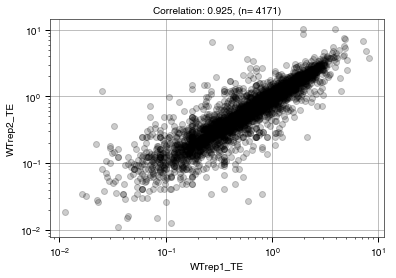

In [17]:
compare_x = 'WTrep1_TE'
compare_y = 'WTrep2_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/WT_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')

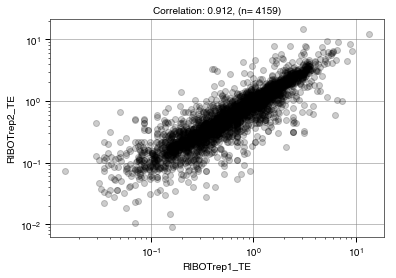

In [18]:
compare_x = 'RIBOTrep1_TE'
compare_y = 'RIBOTrep2_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/RIBOT_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')

# Comparing average values across conditions

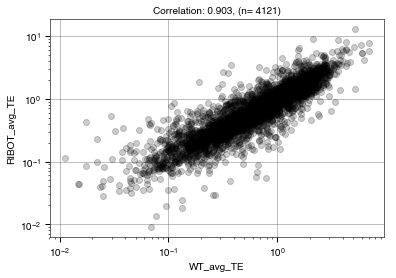

In [19]:
compare_x = 'WT_avg_TE'
compare_y = 'RIBOT_avg_TE'
tempy = df_master[df_master[[compare_x, compare_y]].isnull().any(axis=1)==False]
rho, p = stats.spearmanr(tempy[compare_x], tempy[compare_y])
n = len(tempy.index)

fig, ax = plt.subplots()
ax.loglog(tempy[compare_x], tempy[compare_y], c='k', alpha=0.2, marker='o', linestyle='')
ax.set_xlabel(compare_x)
ax.set_ylabel(compare_y)
ax.set_title('Correlation: {:.3f}, (n= {})'.format(rho, n))
plt.savefig('{}/Condition_TE_comparison.pdf'.format(results_dir), bbox_inches='tight')